In [1]:
import numpy as np
import pandas as pd
import os
import re
import sys
import corner
sys.path.append(os.path.realpath("../src"))
sys.path.append("/home/jbirky/Dropbox/packages/SALib/src")
import SALib
print(SALib.__file__)

import vplanet_inference as vpi
import tidal

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=27)
rc('ytick', labelsize=27)

/home/jbirky/Dropbox/packages/SALib/src/SALib/__init__.py


In [2]:
ctl_stellar = ["078", "079", "080", "081", "082", "083", "084"]
cpl_stellar = ["085", "086", "087", "088", "089", "090", "091"]

def return_var_like(config_ids, results_dir="../analysis/results_sensitivity"):
    
    var_table_s1 = []
    var_table_sT = []
    
    for config_id in config_ids:
        synth = tidal.SyntheticModel(f"../analysis/config/config_{config_id}.yaml", verbose=False, compute_true=False)
        samp = np.load(f"{results_dir}/config_{config_id}/var_global_sensitivity_sample.npz")

        theta, Y = samp['param_values'], samp['Y']
        Y[samp["Y"] > 50] = np.nan
        fy = synth.vpm.run_model(synth.format_theta(ftheta), outsubpath="cpl_stellar_fudicial")

        lnlike = np.array([np.nansum((Y - fy)**2 / sy**2, axis=1)]).T
        synth.variance_global_sensitivity(param_values=theta, Y=lnlike, save=True, subpath="../analysis/results_sensitivity_likelihood")

        age = synth.inparams_all.dict_true['vpl.dStopTime']
        synth.table_s1[int(age)] = synth.table_s1["final.primary.RotPer"]
        synth.table_s1 = synth.table_s1.drop(columns=["final.primary.RotPer"])
        var_table_s1.append(synth.table_s1)
        
        synth.table_sT[int(age)] = synth.table_sT["final.primary.RotPer"]
        synth.table_sT = synth.table_sT.drop(columns=["final.primary.RotPer"])
        var_table_sT.append(synth.table_sT)
        
    df_s1 = pd.concat(var_table_s1, axis=1)
    df_sT = pd.concat(var_table_sT, axis=1)
    
    return df_s1, df_sT, synth


def plot_sens_like(df, inlabels, cmap="bone", title_size=35, annot_size=25):
    
    fig = plt.figure(figsize=[12,10])

    sn.heatmap(df, yticklabels=inlabels, annot=True, annot_kws={"size": annot_size}, cbar=False, vmin=0, vmax=1, cmap=cmap)
    plt.title("Likelihood sensitivity", fontsize=title_size, pad=20)

    plt.xlabel("Age [Myr]", fontsize=title_size)
    plt.ylabel("init conditions", fontsize=title_size)
    plt.tick_params(labelrotation=0)

    plt.close()
    return fig

In [3]:
ftheta = np.array([0.5, 0.5, 10, 10, 1.0, 1.0, 0.3, 5.0, 6.0])
sy = np.array([0.1, 0.1, 1e-5, 1e-3])

df_s1, df_sT, synth = return_var_like(cpl_stellar, results_dir="../analysis/results_sensitivity_hires")
inlabels = synth.inparams_var.labels
inlabels = [re.sub("[\(\[].*?[\)\]]", "", lbl).strip("]") for lbl in inlabels]

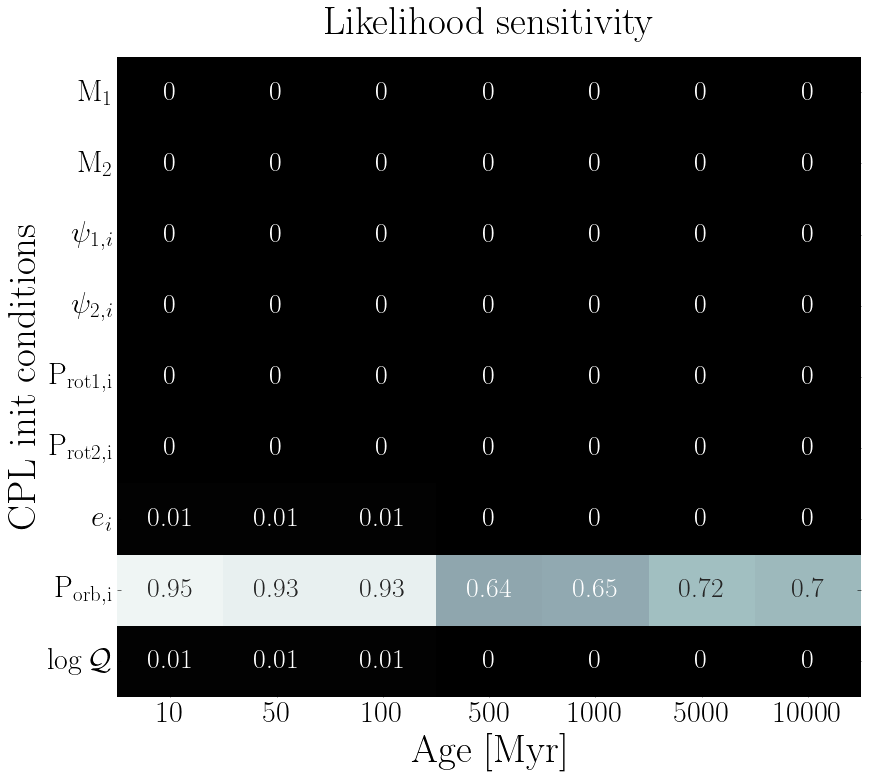

In [4]:
cmap="bone"
title_size=35
annot_size=25

fig = plt.figure(figsize=[12,10])

sn.heatmap(df_s1, yticklabels=inlabels, annot=True, annot_kws={"size": annot_size}, cbar=False, vmin=0, vmax=1, cmap=cmap)
plt.title("Likelihood sensitivity", fontsize=title_size, pad=20)

plt.xlabel("Age [Myr]", fontsize=title_size)
plt.ylabel("CPL init conditions", fontsize=title_size)
plt.tick_params(labelrotation=0)

plt.savefig(f"../figures/sensitivity_cpl_stellar_lnlike.png", bbox_inches="tight")
plt.show()
plt.close()

In [5]:
ftheta = np.array([0.5, 0.5, 10, 10, 1.0, 1.0, 0.3, 5.0, -1.0])
sy = np.array([0.1, 0.1, 1e-5, 1e-3])

df_s1, df_sT, synth = return_var_like(ctl_stellar, results_dir="../analysis/results_sensitivity_hires")
inlabels = synth.inparams_var.labels
inlabels = [re.sub("[\(\[].*?[\)\]]", "", lbl).strip("]") for lbl in inlabels]

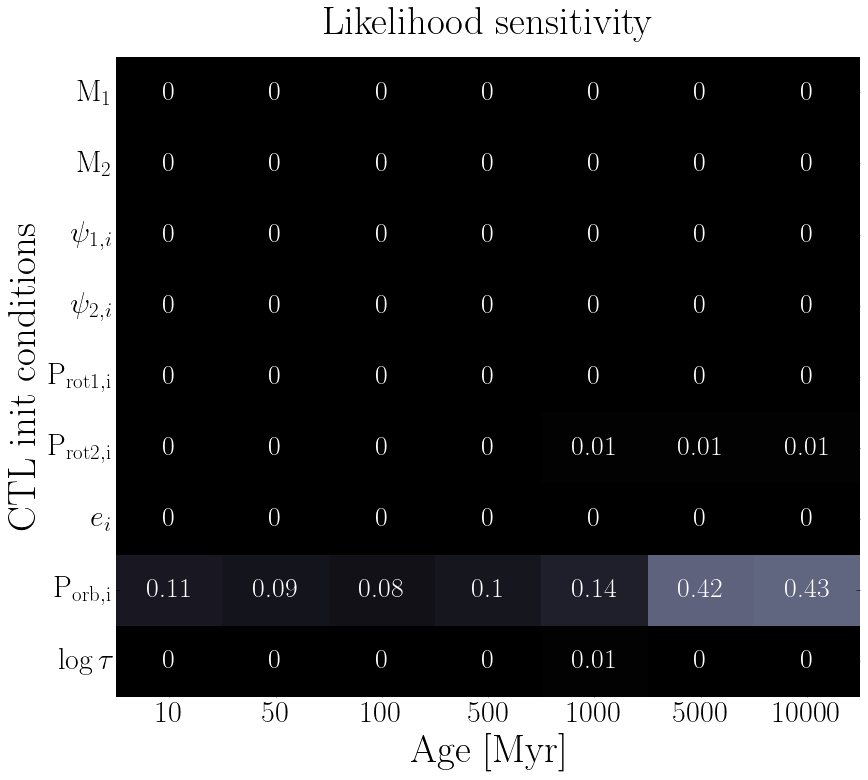

In [6]:
cmap="bone"
title_size=35
annot_size=25

fig = plt.figure(figsize=[12,10])

sn.heatmap(df_s1, yticklabels=inlabels, annot=True, annot_kws={"size": annot_size}, cbar=False, vmin=0, vmax=1, cmap=cmap)
plt.title("Likelihood sensitivity", fontsize=title_size, pad=20)

plt.xlabel("Age [Myr]", fontsize=title_size)
plt.ylabel("CTL init conditions", fontsize=title_size)
plt.tick_params(labelrotation=0)

plt.savefig(f"../figures/sensitivity_ctl_stellar_lnlike.png", bbox_inches="tight")
plt.show()
plt.close()